In [3]:
%load_ext autoreload
%autoreload 2

# Control figure size
figsize=(14, 4)

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from util import util
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings(action='once')
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Gaussian Processes

<div class=big>
    <small>If we want to do better, we need a better predictor</small><br>
What would be some desired properties?
</div>

## Filling Values Using a Model

**Given a gap (i.e. one or more contiguous missing values), the model:**

* Should be able to make a prediction about the missing values
* It should take into account the values that are _before_ the hole
* ...But also those that are _after_ the hole

I.e. it should be able to interpolate _all the available data_

> **Can you think of an ML model that can to that?**

If you have trouble, that's normal: there aren't many!

* Most ML models _cannot_ be used for filling (at least not easily)
* We will see a couple of examples now

## Filling Values Using a Density Estimator

**Density estimation does take into account all data**

...But it cannot easily provide predictions

**To be fair, predictions _can be obtained_ from a density estimator**

* Given an estimator $f(x, \theta)$ for $P(x)$
* ...Then we can find the most likely value for $x$ by solving:

$$
\mathop{\rm argmax}_{x} f(x, \theta)
$$

- This is called a _Maximum A Posteriori (MAP)_

In fact, it's what we naturally get out of most regressors/classifiers

**...But with density estimators, computing the MAP can be _very expensive_**

## Filling Values Using a Regressor

**We can train a (auto)-regressor to predict the next value in a series**

...Then we can fill holes by making a _"rolling forecast"_

* We make one prediction
* We incorporate the prediction in the input
* Then we make another prediction and so on

...But by doing so we only rely on _past_ values

**In fact, the last prediction can be far from the next true value**

* In addition, every iteration of the process introduces approximation
* Formally, we get _compound errors_

This is partly unavoidable: predicting the far future is often difficult

## Gaussian Processes

**One of the few viable ML models is given by _Gaussian Processes (GP)_**

They are not easy to use, but can work well in the correct setting

<center><img src="assets/gp_example.png" width=50%/></center>

* GPs define a probability distribution over an _index (i.e. input) variable_
* The distribution is based on _the available observations_ and _a few assumptions_

## Gaussian Processes

**One of the few viable ML models is given by _Gaussian Processes (GP)_**

<center><img src="assets/gp_example.png" width=50%/></center>

**Assumption 1 (intuitively)**

* _For every value_ of the input variable the distribution is _Gaussian_
* Therefore it can be described by a _mean_ and a _standard deviation_

## Gaussian Processes

**One of the few viable ML models is given by _Gaussian Processes (GP)_**

<center><img src="assets/gp_example.png" width=50%/></center>

**Assumption 2 (intuitively)**

* The stdev depends on the distance between a point and the observations
* So it will be _low_ when we are _close_ to the observations, _high_ when we are _far_ 

## Gaussian Processes

**Formally, things are a bit more complicated**

A GP is a _stochastic process_, i.e. a collection of indexed random variables

* The index variable $x$ represents an input (and can be a vector/tuple)
* Each variable $y_{x}$ represents the output for input $x$
* The index is _continuous_ and the collection is therefore _infinite_

You can think of $y_{x}$ as the value of a (stochastic) function for input $x$

**Some examples:**

* $y_{x}$ could be the rainfall rate at location $x = (\text{latitude}, \text{longitude})$
* $y_{x}$ could be the traffic volume at time $x$

**Each $y_{x}$ follows a Normal Distribution, but the variables are _correlated_**

* Therefore every finite subset of $y_{x}$ variables
* ...Follows a _Multivariate Normal Distribution_

## Multivariate Normal Distritbuion

**Why the multivariate normal distribution?**

* It works for many real world phenomena
* It has a (relatively) simple [closed-form density function](https://en.wikipedia.org/wiki/Multivariate_normal_distribution)

**In particular, the PDF for a MND is defined via:**

* A (vector) mean $\mu$
* A covariance matrix $\Sigma$

By recentering we can assume $\mu = 0$, meaning that _knowing $\Sigma$ is enough_

**Therefore, if we know $\Sigma$ we can easily compute**

* The joint density $f(\bar{y}_{\bar{x}})$ for a set of observations
* The conditional density $f(y_x \mid \bar{y}_{\bar{x}})$ of a new observation $y_x$, given $\bar{y}_{\bar{x}}$

## Why do We Care?

**We need the conditional density to perform inference!**

<center><img src="assets/gp_example.png" width=50%/></center>

* The line and grey areas represent the conditional density $f(y_x \mid \bar{y}_{\bar{x}})$ of $y_x$
* ...Based on the available observations, i.e. $\bar{y}_{\bar{x}}$

## Why do We Care

**We need the joint density to perform training!**

...Because in practice we _don't know $\Sigma$_

* Therefore we'll assume that $\Sigma$ is a _parameterized function $\Sigma(\theta)$_
* ...And we can optimize the parameters $\theta$ for maximum likelihood

**Formally, given a set of training observations $\bar{y}_{\bar{x}}$**

...We can calibrate the parameters by solving a problem in the form:

$$
\mathop{\rm argmax}_{\theta} f(\bar{y}_{\bar{x}}, \theta)
$$

* Here we are not using a product of probabilities over the training set
* ...Because the $y_x$ variables are correlated
* No worries: since we have the joint PDF, we use it directly

## Which Covariance Matrix?

**We still have one big problem**

Say that we a covariance matrix $\Sigma$ for a set of observations $\bar{y}_{\bar{x}}$

* Now we want to perform inference for an input value $x$
* Formally: we want to compute $f(y_x \mid \bar{y}_{\bar{x}})$

**In principle, we can use the formula:**

$$
f(y_x \mid \bar{y}_{\bar{x}}) = \frac{f(y_x, \bar{y}_{\bar{x}})}{f(\bar{y}_{\bar{x}})}
$$

* By using our $\Sigma$, we can easily compute $f(\bar{y}_{\bar{x}})$
* ...But what about $f(y_x, \bar{y}_{\bar{x}})$?

## Which Covariance Matrix?

**Our $\Sigma$ refers to our set of observed variables $\bar{y}_{\bar{x}}$**

Therefore, if we have $n$ variables, our matrix will be $n \times n$

$$\Sigma_{\bar{x}} = \left(\begin{array}{cccc}
\sigma_{\bar{x}_1,\bar{x}_1} & \sigma_{\bar{x}_1,\bar{x}_2} & \cdots & \sigma_{\bar{x}_1,\bar{x}_n} \\
\sigma_{\bar{x}_2,\bar{x}_1} & \sigma_{\bar{x}_2,\bar{x}_2} & \cdots & \sigma_{\bar{x}_2,\bar{x}_n} \\
\vdots & \vdots & \ddots & \vdots \\
\sigma_{\bar{x}_n,\bar{x}_1} & \sigma_{\bar{x}_n,\bar{x}_2} & \cdots & \sigma_{\bar{x}_n,\bar{x}_2}
\end{array}\right)$$

* In every cell we have the covariance for variables $\bar{y}_{\bar{x}_i}$ and $\bar{y}_{\bar{x}_j}$
* With this matrix, we can compute $f(\bar{y}_{\bar{x}})$

## Which Covariance Matrix?

**However, $f(y_x, \bar{y}_{\bar{x}})$ refers to _one more variable_**

Meaning that it will be specified via an $(n+1) \times (n+1)$ matrix!

$$\Sigma_{x,\bar{x}} = \left(\begin{array}{ccccc}
\color{red}{\sigma_{x,x}} & \color{red}{\sigma_{x,\bar{x}_1}} & \color{red}{\sigma_{x,\bar{x}_2}} & \color{red}{\cdots} & \color{red}{\sigma_{x,\hat{x}_2}} \\
\color{red}{\sigma_{\bar{x}_1,x}} & \sigma_{\bar{x}_1,\bar{x}_1} & \sigma_{\bar{x}_1,\bar{x}_2} & \cdots & \sigma_{\hat{x}_1,\hat{x}_n} \\
\color{red}{\sigma_{\bar{x}_2,x}} & \sigma_{\bar{x}_2,\bar{x}_1} & \sigma_{\bar{x}_2,\bar{x}_2} & \cdots & \sigma_{\bar{x}_2,\bar{x}_n} \\
\color{red}{\vdots} & \vdots & \ddots & \vdots \\
\color{red}{\sigma_{\bar{x}_n,x}} & \sigma_{\bar{x}_n,\bar{x}_1} & \sigma_{\bar{x}_n,\bar{x}_2} & \cdots & \sigma_{\bar{x}_n,\bar{x}_2}
\end{array}\right)$$

* Assuming that $\bar{y}_{\bar{x}}$ are the training observations
* ...We could define $\sigma_{\bar{x}_1, \bar{x}_2}$ at training time

**But how do we define _the new covariances_, i.e. those related to $y_x$?**

## Defining the Covariance Matrix

**We assume that covariance can be _built from a set of inputs_**

Let $x$ refer now to a vector of values for the index variable

* Given two variables $y_{x_i}$ and $y_{x_j}$
* We specify their covariance via parameterized _kernel function_ $K_\theta(x_i, x_j)$
* $K$ typically depends on the distance between input values

**Given any finite set of variables $\{y_{x_1}, \ldots y_{x_n}\}$, the covariance matrix is:**

$$\Sigma = \left(\begin{array}{cccc}
K_\theta(x_1, x_1) & K_\theta(x_1, x_2) & \cdots & K_\theta(x_1, x_n) \\
K_\theta(x_2, x_1) & K_\theta(x_2, x_2) & \cdots & K_\theta(x_2, x_n) \\
\vdots & \vdots & \vdots & \vdots \\
K_\theta(x_n, x_1) & K_\theta(x_n, x_2) & \cdots & K_\theta(x_n, x_n) \\
\end{array}\right)$$

...Which we can computed based on the input (and the parameters) alone!

## The Whole Picture

**In practice, at _training time_**

* Pick a _parameterized_ kernel function $K_{\theta}(x_i, x_j)$
* Collect training observations $\bar{y}_{\bar{x}}$
* Optimize the kernel for maximum likelihood (e.g. via gradient descent)

Both the parameters $\theta$ _and the observations $\bar{y}_\bar{x}$_ are stored in the model

* This is similar to what we have in Kernel Density Estimation

**At inference time:**

* Given a new input (i.e. index) value $x$
* We obtain the covariance matrix $\Sigma_{\bar{x}}$
* We obtain the covariance matrix $\Sigma_{x, \bar{x}}$

...And with this we can completely characterize $f(y_x, \mid \bar{y}_\bar{x})$

## Gaussian Processes in scikit-learn

**Let's see how to use Gaussian Processes in scikit-learn**

First, let us choose a function as our ground truth

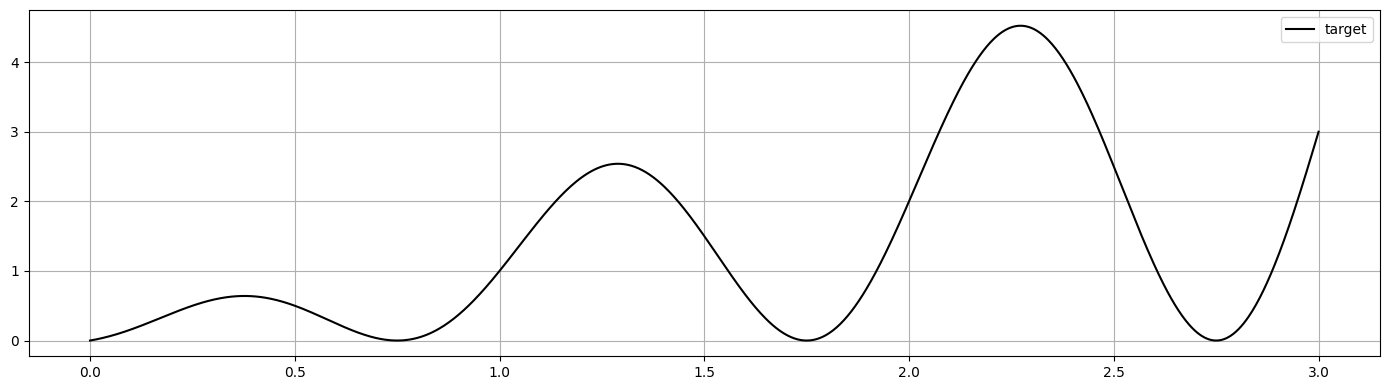

In [4]:
f = lambda x: x * np.sin(2*np.pi*x) + x # target function
x = np.linspace(0, 3, 1000)
y = pd.Series(index=x, data=f(x))
util.plot_gp(target=y, figsize=figsize)

## Gaussian Processes in scikit-learn

**Then we build a small training set:**

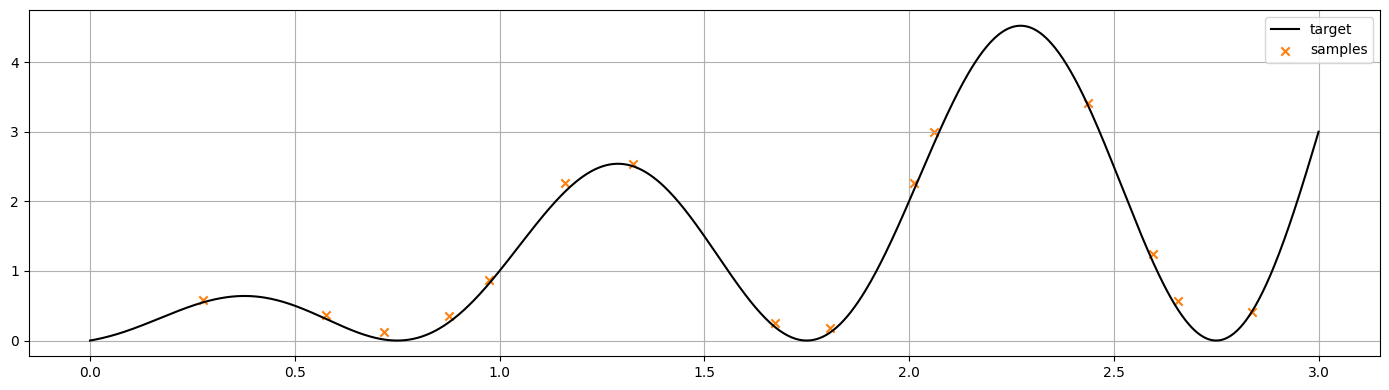

In [5]:
np.random.seed(42)
n_tr = 15
x_tr = np.linspace(0.2, 2.8, n_tr) + 0.2*np.random.rand(n_tr)
x_tr.sort()
y_tr = pd.Series(index=x_tr, data=f(x_tr) + 0.2*np.random.rand(n_tr))
util.plot_gp(target=y, samples=y_tr, figsize=figsize)

## Gaussian Processes in scikit-learn

**Now we are where we would normally start in a data analysis**

...And we need to choose a kernel among are [many available options](https://scikit-learn.org/stable/modules/gaussian_process.html)

* Since we have 15 training points
* This will be used at training time to build a $15 \times 15$ covariance matrix

**We will start with a simple _Radial Basis Function_ (i.e. Gaussian) kernel**

$$
K(x_i, x_j) = e^{-\frac{d(x_i, x_j)^2}{2l}}
$$

The covariance _decreases with the (Euclidean) distance_ $d(x_i, x_j)$:

* Intuitively, _the closer the points, the higher the correlation_
* The $l$ parameter (_scale_) control the rate of the reduction

## Gaussian Processes in scikit-learn

**Here's how to use an RBF kernel in scikit-learn**

In [6]:
from sklearn.gaussian_process.kernels import RBF

kernel = RBF(1, (1e-2, 1e2))

**The RBF kernel has a single parameter, representing its _scale_**

The extra (tuple) parameter represents a pair of _bounds_

* During training, only values within the boundaries will be considere

**Bounds can be very useful for controlling the training process**

* They should be chosen based on the available domain information
* Multiples educated guesses are fine when little is known about the problem

## Gaussian Processes in scikit-learn

**Now we can train a Gaussian Process**

In [7]:
from sklearn.gaussian_process import GaussianProcessRegressor
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gp.fit(y_tr.index.values.reshape(-1,1), y_tr.values) # needs 2D input

GaussianProcessRegressor(kernel=RBF(length_scale=1), n_restarts_optimizer=9)

* Training uses Gradient Descent to maximize the likelihood of the training data
* _Restarts_ are needed to mitigate issues due to local optima

**Training can be an expensive process:**

* Building the covariance matrix runs in $O(n^2)$ (where $n$ is the training set size)
* ...And we need to that repeatedly during optimization!

## Gaussian Processes in scikit-learn

**Finally, we can obtain the predictions:**

In [8]:
xp, std = gp.predict(x.reshape(-1,1), return_std=True)
xp = pd.Series(index=y.index, data=xp)
std = pd.Series(index=y.index, data=std)

The "predictions" are _not point estimates_!

* We actually get those (i.e. the means, called `xp` in the code)
* ...But we also obtain standard deviations

**The model output is a fully characterized conditional distribution**

The distribution is conditional on:

* The input value $x$ (passed at inference time)
* All the training observations (stored in the model)

## Gaussian Processes in scikit-learn

**We can now plot the predictions**

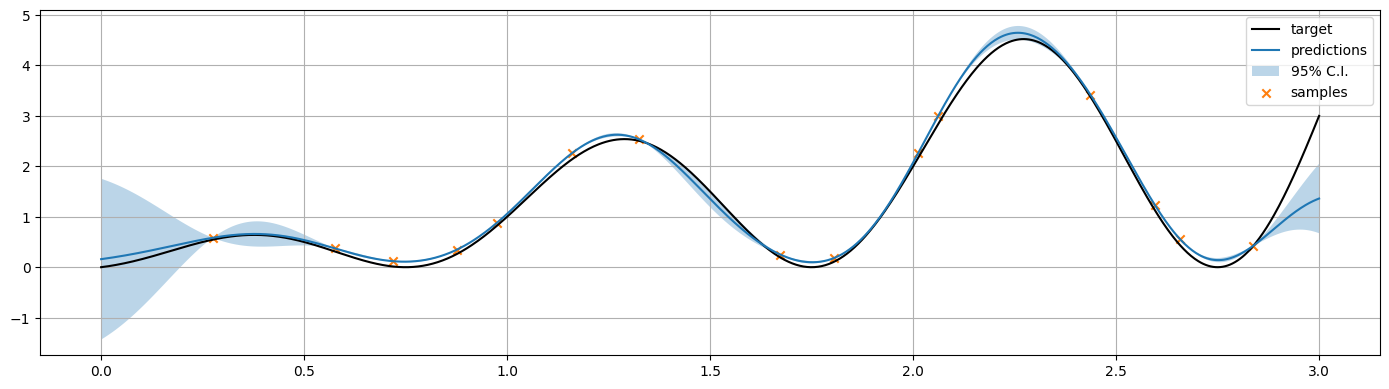

In [9]:
util.plot_gp(target=y, samples=y_tr, pred=xp, std=std, figsize=figsize)

**Obtaining a full distribution as output is cool**

* We obtain an estimated value (the mean)
* ...And we get to know how certain the model is about that

## Behind the Scenes

**Let's see how prediction works with a numeric example**

We want a prediction for $x = 2.5$, i.e. $y_{2.5}$

* We consider two separate training set (and pre-optimized kernel parameters)
* The first set contains only $(\bar{x}_9, \bar{y}_{\bar{x}_9}) \simeq (2.01, 2.27)$
* The second set contains only $(\bar{x}_0, \bar{y}_{\bar{x}_0}) \simeq (0.27, 0.58)$

**The covariance matrices in the two cases are therefore:**

$$
\Sigma_{y_x, \bar{y}_{\bar{x}_9}} = \left(\begin{array}{cc}
K(2.01, 2.01) & K(2.01, 2.5) \\
K(2.5, 2.01) & K(2.5, 2.5) \\
\end{array}\right)
$$
$$
\Sigma_{y_x, \bar{y}_{\bar{x}_0}} = \left(\begin{array}{cc}
K(0.27, 0.27) & K(0.27, 2.5) \\
K(2.5, 0.27) & K(2.5, 2.5) \\
\end{array}\right)
$$

## Behind the Scenes

**Let's actually build the matrices in Python**

* Note: scikit-learn kernels are not designed to be used on individual points
* So, for this we will rely on basic numpy methods

**We start with $\bar{x}_9$ and $x$, which are _close to each other_**

In [10]:
from scipy.stats import multivariate_normal
X9, X0, X = [[x_tr[9]]], [[x_tr[0]]], [[2.5]] # Must be 2D
sigma_9x = np.array([[kernel(X9, X9)[0,0], kernel(X9, X)[0,0]],
                    [kernel(X, X9)[0,0], kernel(X, X)[0,0]]])
f_9x = multivariate_normal([0, 0], cov=sigma_9x)

**Then we do the same for $\bar{x}_0$ and $x$, which are _far apart_**

In [11]:
sigma_0x = np.array([[kernel(X0, X0)[0,0], kernel(X0, X)[0,0]],
                    [kernel(X, X0)[0,0], kernel(X, X)[0,0]]])
f_0x = multivariate_normal([0, 0], cov=sigma_0x)

## Behind the Scenes

**$\bar{x}_9$ and $x$ are _close to each other_, so $\bar{y}_{\bar{x}_9}$ and $y_x$ are _strongly correlated_**

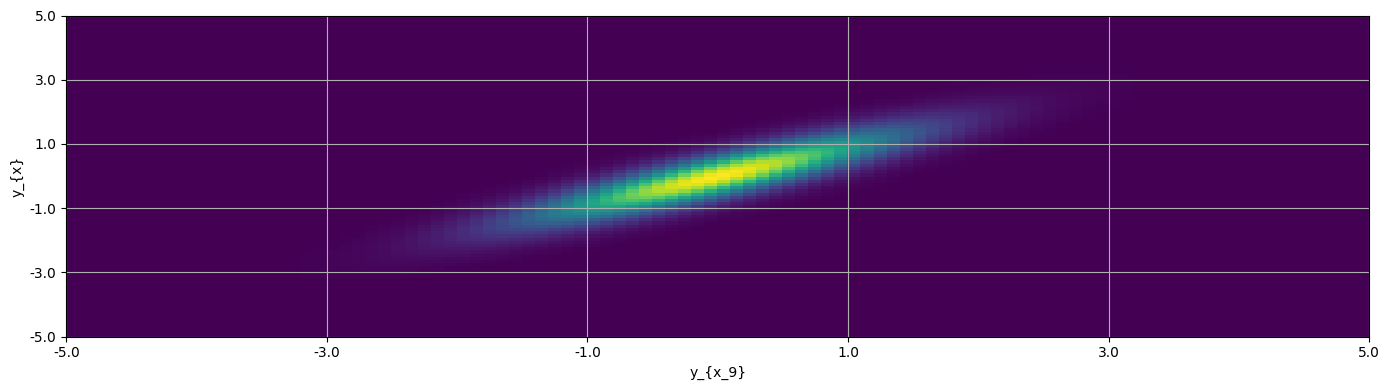

In [12]:
yr = np.linspace(-5, 5, 100)
util.plot_distribution_2D(f_9x, yr, yr, figsize=figsize)
plt.xlabel('y_{x_9}'); plt.ylabel('y_{x}'); plt.tight_layout()

* If we know _neither_ $\bar{y}_{\bar{x}_9}$ nor $y_x$, we can only say that they are likely _both zero_

## Behind the Scenes

**But we _do know_ $\bar{y}_{\bar{y}_9}$! So, we can use this information**

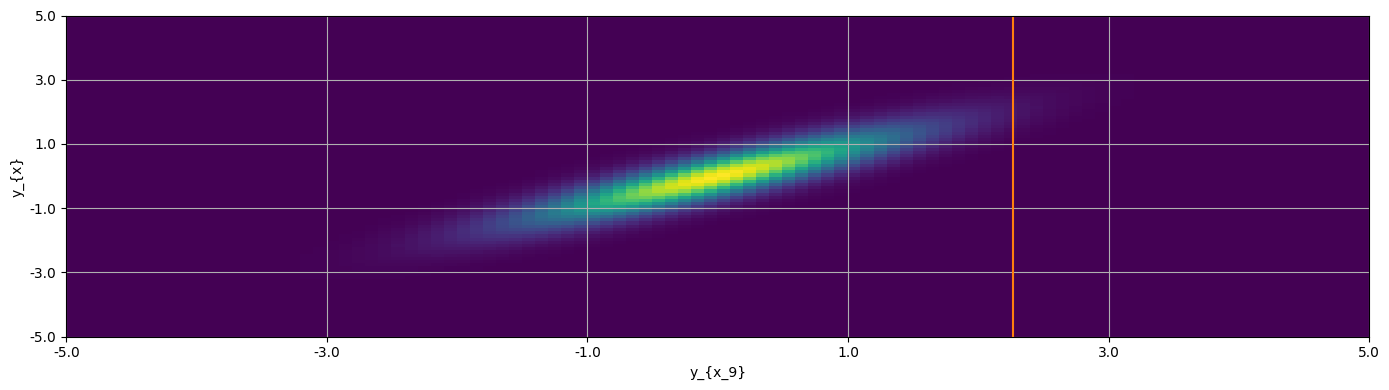

In [13]:
util.plot_distribution_2D(f_9x, yr, yr, figsize=figsize)
plt.axvline(10*(y_tr[x_tr[9]] + 5), color='tab:orange');
plt.xlabel('y_{x_9}'); plt.ylabel('y_{x}'); plt.tight_layout()

* Given the observation, the most likely value for $y_{x}$ is $\simeq 2$

## Behind the Scenes

**$\bar{x}_0$ and $x$ are _far apart_, so $\bar{y}_{\bar{x}_0}$ and $y_x$ are _loosely correlated_**

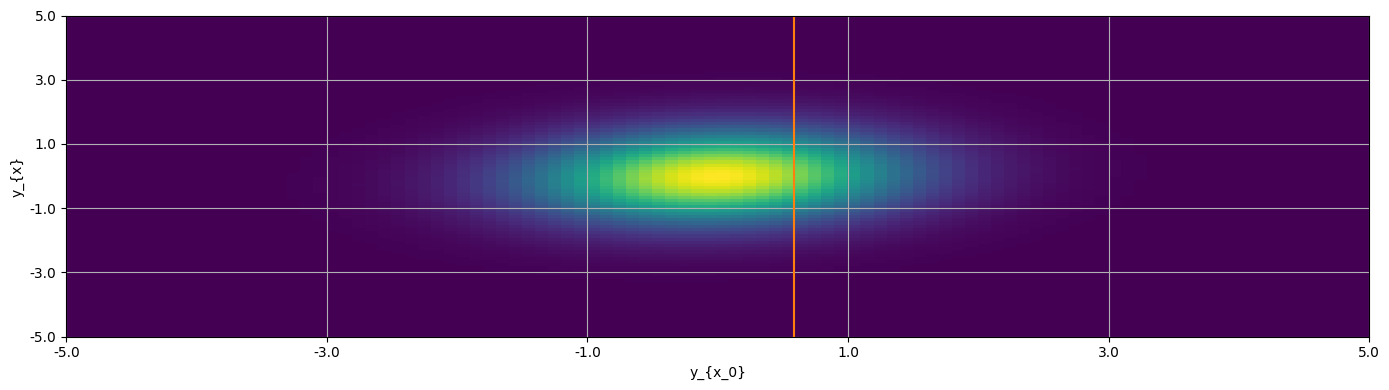

In [14]:
util.plot_distribution_2D(f_0x, yr, yr, figsize=figsize)
plt.axvline(10*(y_tr[x_tr[0]] + 5), color='tab:orange');
plt.xlabel('y_{x_0}'); plt.ylabel('y_{x}'); plt.tight_layout()

* Knowing $\bar{y}_{\bar{x}_0}$ is not going to be of much help here

## Memento

**So, a few key insight to keep in mind:**

* Superficially, GPs behave like _functions that output probability distribution_
* Internally, they store _the kernel_, defining how all the points are correlated
* _A set of observations_, used to obtain conditional distributions

**In scikit-learn:**

When we call the `fit` method:

* The optimizer _adjusts the kernel parameters_
* ...And _the observations $\bar{y}_{\bar{x}}$ are stored_

When we call the `predict` method:

* The covariance matrix is built
* The model computes the conditional distributions

## How to Improve the Model

**We can improve the model by choosing a more appropriate kernel**

* Let's (cheat and) look again at our ground truth and training data
* Which patterns and properties do you notice?

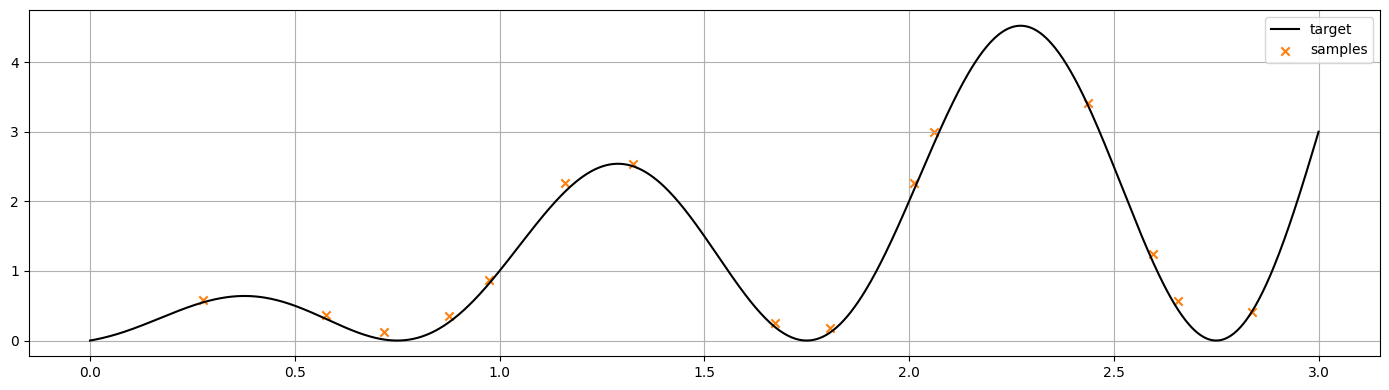

In [15]:
util.plot_gp(target=y, samples=y_tr, figsize=figsize)

**We have some _noise_, a _period_, and a _trend_**

## How to Improve the Model

**So, let us deal with the noise first**

In [16]:
from sklearn.gaussian_process.kernels import WhiteKernel

kernel = WhiteKernel(0.1, (1e-2, 1e2))
kernel += RBF(1, (1e-2, 1e2))

**`WhiteKernel` captures the presence of _noise_ in the data**

$$
K(x_i, x_j) = \sigma^2 \text{ iff } x_i = x_j, 0 \text{ otherwise}
$$


* The only parameter of `WhiteKernel` represents the noise level $\sigma^2$
* A small noise level prevents overfitting
* ...But too much noise leads to useless predictions!

## How to Improve the Model

**It's often a good idea to have _magnitude parameters_ in the kernel**

In [17]:
from sklearn.gaussian_process.kernels import ConstantKernel

kernel = WhiteKernel(0.1, (1e-2, 1e2))
kernel += ConstantKernel(1, (1e-2, 1e2)) * RBF(1, (1e-2, 1e2))

**`ConstantKernel` is a constant factor (in this case a relative weight)**

* ...And allows the optimizer to tune the magnitude of the RBF kernel

**Let's repeat training again:**

In [18]:
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gp.fit(y_tr.index.values.reshape(-1,1), y_tr.values) # needs 2D input
print(gp.kernel_)

WhiteKernel(noise_level=0.01) + 2.21**2 * RBF(length_scale=0.321)


## How to Improve the Model

**Let us see the new predictions**

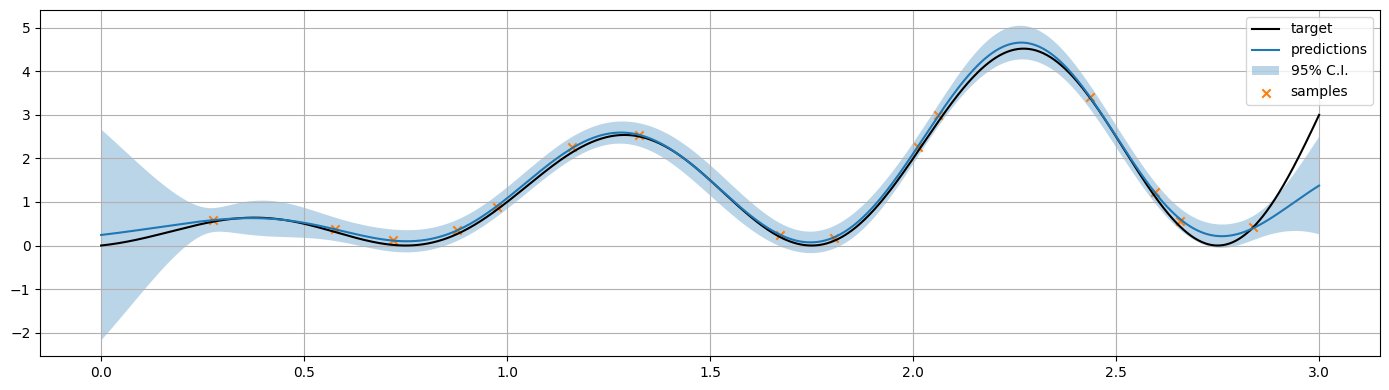

In [19]:
xp, std = gp.predict(x.reshape(-1,1), return_std=True)
util.plot_gp(target=y, samples=y_tr, pred=pd.Series(index=y.index, data=xp),
             std=pd.Series(index=y.index, data=std), figsize=figsize)

* Better, since the black curve is mostly in the confidence interval
* ...But we are still not exploiting the period and the trend

## How to Improve the Model

**So, let us take them into account, starting with the _period_**

In [20]:
from sklearn.gaussian_process.kernels import ExpSineSquared
kernel = WhiteKernel(0.1, (1e-2, 1e2))
kernel += ConstantKernel(1, (1e-2, 1e2)) * RBF(1, (1e-2, 1e2))
kernel += ExpSineSquared(1, 1, (1e-1, 1e1), (1e-1, 1e1))

**`ExpSineSquared` captures the period:**

$$
K(x_i, x_j) = e^{-2 \frac{\sin^2 \left(\pi \frac{d(x_i,x_j)}{p}\right)}{l^2}}
$$

* The correlation grows if the distance is close to a multiple of the period $p$
* The scale parameter $l$ controls the rate of decrease/increase
* In the implementation, the first parameter is $l$ and the second $p$

## How to Improve the Model

**Now, let's try to capture the _trend_**

In [21]:
from sklearn.gaussian_process.kernels import DotProduct
kernel = WhiteKernel(0.1, (1e-2, 1e2))
kernel += ConstantKernel(1, (1e-2, 1e2)) * RBF(1, (1e-2, 1e2))
kernel += ExpSineSquared(1, 1, (1e-1, 1e1), (1e-1, 1e1))
kernel += DotProduct(1, (1e-2, 1e2))

**`DotProduct` (somewhat) captures the trend:**

$$
K(x_i, x_j) = \sigma^2 + x_i x_j
$$

* The larger the $x$ values, the larger the correlation
* This allows the distance from the mean (which is zero) to grow
* The $\sigma$ parameter controls the base level of correlation
* Unlike all kernels so far `DotProduct` is _not translation-invariant_

## How to Improve the Model

**The new predictions are a bit better at the edges of the plot**

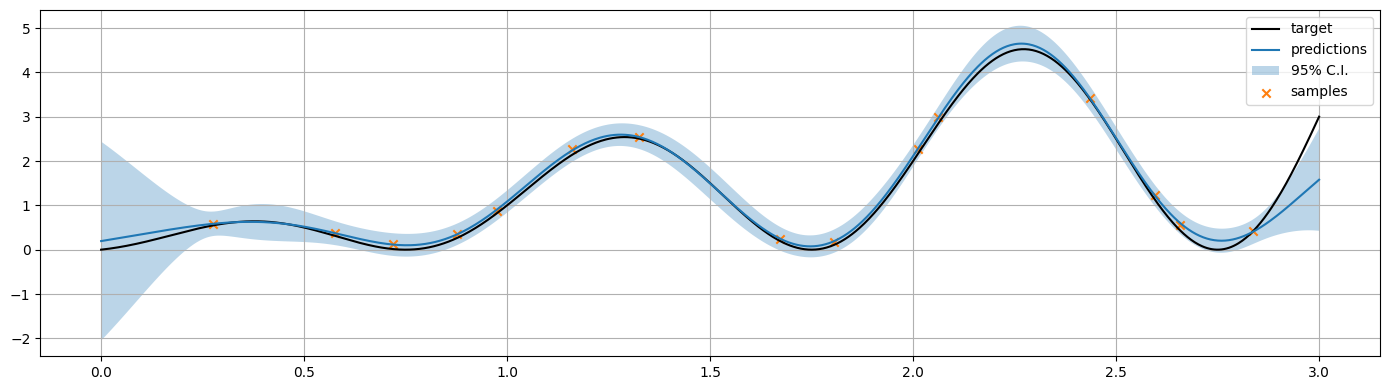

In [22]:
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gp.fit(y_tr.index.values.reshape(-1,1), y_tr.values) # needs 2D input
xp, std = gp.predict(x.reshape(-1,1), return_std=True)
util.plot_gp(target=y, samples=y_tr, pred=pd.Series(index=y.index, data=xp),
             std=pd.Series(index=y.index, data=std), figsize=figsize)

* Notice how the C.I. grows close to the sides?
* GPs tend to _interpolate well_ and _extrapolate poorly_